In [88]:
!pip install tensorflow numpy pandas matplotlib sklearn

# Bringing In Data

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
df = pd.read_csv('train.csv')

In [31]:
newdf = df.head(17500)

In [32]:
newdf.shape

(17500, 8)

# Preprocessing

In [33]:
from tensorflow.keras.layers import TextVectorization

In [34]:
newdf.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [35]:
newdf[newdf.columns[2:]].iloc[0]

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 0, dtype: int64

In [36]:
X = newdf['comment_text']
Y = newdf[df.columns[2:]].values

In [37]:
vectorizer = TextVectorization(max_tokens = 200000,
                              output_sequence_length = 1800,
                               output_mode = 'int')

In [38]:
vectorizer.adapt(X.values)

In [39]:
vectorized_text = vectorizer(X.values)

In [40]:
vectorized_text

<tf.Tensor: shape=(17500, 1800), dtype=int64, numpy=
array([[  602,    76,     2, ...,     0,     0,     0],
       [52075,    54,  2282, ...,     0,     0,     0],
       [  492,   433,    69, ...,     0,     0,     0],
       ...,
       [ 2531,     9,    12, ...,     0,     0,     0],
       [   74,   127,    89, ...,     0,     0,     0],
       [   23,    14,   560, ...,     0,     0,     0]], dtype=int64)>

In [48]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, Y))
dataset = dataset.cache()
dataset = dataset.shuffle(17500)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [49]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# Creating the model

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [51]:
MAX_FEATURES = 200000

In [52]:
model = Sequential()
model.add(Embedding(MAX_FEATURES+1, 32))
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='sigmoid'))

In [53]:
model.compile(loss = 'BinaryCrossentropy', optimizer = 'Adam')

In [54]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                16640     
 onal)                                                           
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 256)               33024     
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dense_11 (Dense)            (None, 6)                 774       
                                                      

In [55]:
r = model.fit(train, epochs = 3, validation_data = val)

Epoch 1/3
765/765 [==============================] - 685s 885ms/step - loss: 0.1101 - val_loss: 0.0659
Epoch 2/3
765/765 [==============================] - 1455s 2s/step - loss: 0.0586 - val_loss: 0.0488
Epoch 3/3
765/765 [==============================] - 674s 882ms/step - loss: 0.0444 - val_loss: 0.0390


In [56]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

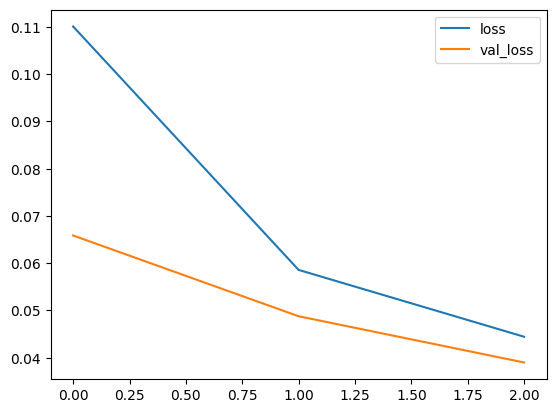

In [57]:
plt.figure(figsize=(8,5))
pd.DataFrame(r.history).plot()
plt.show()

# Evaluating the model

In [63]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [64]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 318ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [65]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [66]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [67]:
for batch in test.as_numpy_iterator(): 
    X_true, y_true = batch

    yhat = model.predict(X_true)
    
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 135ms/step


In [68]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8099415302276611, Recall:0.7589040994644165, Accuracy:0.44954127073287964


In [69]:
model.save('toxicity.h5')

C:\Users\welcome\anaconda3\envs\tf2.14\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [70]:
model = tf.keras.models.load_model('toxicity.h5')

# Testing

In [104]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    for idx, col in enumerate(df.columns[2:]):
        print("{}: {}".format(col, results[0][idx]>0.5))

In [105]:
score_comment("You're an asshole!")

1/1 [==============================] - 0s 142ms/step
toxic: True
severe_toxic: False
obscene: True
threat: False
insult: True
identity_hate: False


In [109]:
score_comment("What a lovely day!")

1/1 [==============================] - 0s 124ms/step
toxic: False
severe_toxic: False
obscene: False
threat: False
insult: False
identity_hate: False


In [107]:
score_comment("Fat piece of shit")

1/1 [==============================] - 0s 157ms/step
toxic: True
severe_toxic: False
obscene: True
threat: False
insult: True
identity_hate: False


In [108]:
score_comment("I think he is a gay fag")

1/1 [==============================] - 0s 94ms/step
toxic: True
severe_toxic: False
obscene: True
threat: False
insult: True
identity_hate: False
